In [77]:
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import os
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from typing import Annotated,Literal

In [78]:
load_dotenv()

True

In [79]:
#  Initialize Endpoint with the correct task
llm = HuggingFaceEndpoint(
    repo_id="openai/gpt-oss-20b",
    task="text-generation",  
    
)

# 3. Wrap in Chat Interface
model = ChatHuggingFace(llm=llm)

In [80]:


# Define your evaluation schema
class Evalution(BaseModel):
    sentiment: Literal["positive", "negative", "both"] = Field(description='Sentiment of the review')
    

# Create parser
parser = JsonOutputParser(pydantic_object=Evalution)

# Get format instructions
format_instructions = parser.get_format_instructions()

# Build prompt with JSON format instructions
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="Find the sentiment analysis of the review:\n{review}\n\n{format_instructions}",
    input_variables=["review"],
    partial_variables={"format_instructions": format_instructions},
)

# Chain: prompt | model | parser
chain = prompt | model | parser
review = """
The device has some genuinely, impressive features, but using it has been a roller coaster. On the positive side, the display quality is outstanding, and the speakers are surprisingly good for this price range. I also appreciate how lightweight it feels, and the camera performance exceeded my expectations.

However, the overall experience is far from perfect. The system crashes randomly at least twice a day, and the battery life is wildly inconsistent—sometimes it lasts eight hours, other times it dies in under three. The customer support team was polite but completely unhelpful, which made the troubleshooting process even more frustrating. I like the product when it works, but the reliability issues make it hard to fully recommend.
"""
# Invoke
result = chain.invoke({"review": review})
# `result` will be a parsed pydantic object or dict containing the sentiment field
# Example usage: try to access the parsed sentiment as `result['sentiment']` or `result.sentiment` if needed


In [81]:
result['sentiment']  # Accessing the sentiment field from the result

'both'

In [82]:
class ReviewSentiment(TypedDict):
    review: str
    sentiment: Literal["positive", "negative", "both"]
    response: str

In [83]:
graph= StateGraph(ReviewSentiment)


In [84]:
def analyze_review(state: ReviewSentiment):
    state['sentiment']=chain.invoke({"review": state['review']})
    return {'sentiment': state['sentiment']}

In [85]:
def positive_response(state: ReviewSentiment):
    prompt = PromptTemplate(
        template="Write a positive response to the following review:\n{review}",
        input_variables=["review"],
    )
    response_chain = prompt | model
    response = response_chain.invoke({"review": state['review']})
    response_text = response.content
    return {'response': response_text}

In [86]:
def negative_response(state: ReviewSentiment):
    prompt = PromptTemplate(
        template="Write a negative response to the following review:\n{review}",
        input_variables=["review"],
    )
    response_chain = prompt | model
    response = response_chain.invoke({"review": state['review']})
    response_text = response.content
    return {'response': response_text}

In [87]:
def balanced_response(state: ReviewSentiment):
    prompt = PromptTemplate(
        template="Write a balanced response to the following review:\n{review}",
        input_variables=["review"],
    )
    response_chain = prompt | model
    response = response_chain.invoke({"review": state['review']})
    response_text = response.content
    return {'response': response_text}

In [88]:
def check_sentiment(state: ReviewSentiment) -> Literal['positive_response','negative_response','balanced_response']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    elif state['sentiment'] == 'negative':
        return 'negative_response'
    else:
        return 'balanced_response'

In [89]:
                "# Define nodes (idempotent — safe to re-run)",
                "for name, fn in [",
                "    ('analyze_review', analyze_review),",
                "    ('positive_response', positive_response),",
                "    ('negative_response', negative_response),",
                "    ('balanced_response', balanced_response),",
                "]:",
                "    if name not in graph.nodes:",
                "        graph.add_node(name, fn)",
                "",
                "# Add edges (idempotent guards)",
                "try:",
                "    if ('analyze_review' in graph.nodes) and ((START, 'analyze_review') not in getattr(graph, 'edges', set())):",
                "        graph.add_edge(START, 'analyze_review')",
                "except Exception:",
                "    pass",
                "",
                "# Conditional edges (may be safe to call multiple times)",
                "try:",
                "    graph.add_conditional_edges('analyze_review', check_sentiment)",
                "except Exception:",
                "    pass",
                "",
                "for target in ['positive_response', 'negative_response', 'balanced_response']:",
                "    try:",
                "        if (target in graph.nodes) and ((target, END) not in getattr(graph, 'edges', set())):",
                "            graph.add_edge(target, END)",
                "    except Exception:",
                "        pass",
                ""

In [90]:
workflow=graph.compile()

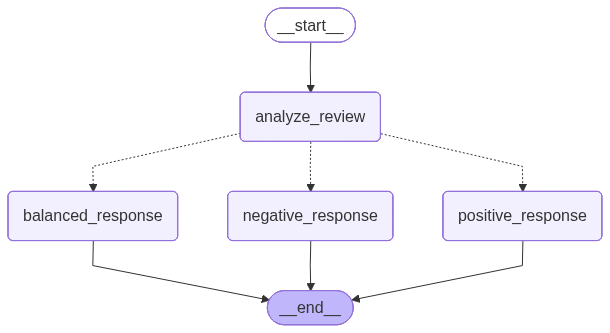

In [91]:
workflow

In [92]:
review = """
The device has some genuinely, impressive features, but using it has been a roller coaster. On the positive side, the display quality is outstanding, and the speakers are surprisingly good for this price range. I also appreciate how lightweight it feels, and the camera performance exceeded my expectations.

However, the overall experience is far from perfect. The system crashes randomly at least twice a day, and the battery life is wildly inconsistent—sometimes it lasts eight hours, other times it dies in under three. The customer support team was polite but completely unhelpful, which made the troubleshooting process even more frustrating. I like the product when it works, but the reliability issues make it hard to fully recommend.
"""

In [97]:
initial_state={
    'review': review 
}
workflow.invoke(initial_state)

{'review': '\nThe device has some genuinely, impressive features, but using it has been a roller coaster. On the positive side, the display quality is outstanding, and the speakers are surprisingly good for this price range. I also appreciate how lightweight it feels, and the camera performance exceeded my expectations.\n\nHowever, the overall experience is far from perfect. The system crashes randomly at least twice a day, and the battery life is wildly inconsistent—sometimes it lasts eight hours, other times it dies in under three. The customer support team was polite but completely unhelpful, which made the troubleshooting process even more frustrating. I like the product when it works, but the reliability issues make it hard to fully recommend.\n',
 'sentiment': {'sentiment': 'both'},
 'response': 'Hi there,\n\nThank you for taking the time to share your experience. We’re thrilled to hear that you’re enjoying the standout display, surprisingly solid speakers, lightweight feel, and 